In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, r2_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
import os

os.getcwd()

'/home/kevinhav/projects/flight_numbers'

In [3]:
fn_path= Path('data/raw/colin_kuskie_flight_numbers.csv')
dims_path = Path('data/raw/pdga-approved-disc-golf-discs_2023-09-07T18-20-28.csv')

In [4]:
fn_cols_to_keep = ['Name', 'Speed', 'Glide', 'Turn', 'Fade']

dims_cols_to_keep = ['Manufacturer / Distributor', 'Disc Model', 
       'Diameter (cm)', 'Height (cm)', 'Rim Depth (cm)',
       'Inside Rim Diameter (cm)', 'Rim Thickness (cm)',
       'Rim Depth / Diameter Ratio (%)', 'Rim Configuration',
       'Flexibility (kg)']

X_cols = ['Diameter (cm)','Height (cm)', 'Rim Depth (cm)',
       'Inside Rim Diameter (cm)', 'Rim Thickness (cm)',
       'Rim Depth / Diameter Ratio (%)', 'Rim Configuration',
       'Flexibility (kg)']

#y_cols = ['Speed', 'Glide', 'Turn', 'Fade']
y_cols = ['Speed']

In [5]:
def get_data(fn_path, dims_path):
    df_flight_nums = pd.read_csv(fn_path, usecols=fn_cols_to_keep, dtype={'Name':'category', 'Speed':'category', 'Glide':'category', 'Turn':'category', 'Fade':'category', 'Brand':'category', 'Manufacturer': 'category'})
    df_disc_dims = pd.read_csv(dims_path, usecols=dims_cols_to_keep, dtype={'Manufacturer / Distributor':'category', 'Disc Model':'category', 'Max Weight (gr)':'float32', 'Diameter (cm)':'float32', 'Height (cm)':'float32', 'Height (cm)': 'float32', 'Rim Depth (cm)':'float32', 'Rim Thickness (cm)':'float32', 'Rim Depth / Diameter Ratio (%)':'float32', 'Rim Configuration':'float32', 'Flexibility (kg)':'float32'})

    return df_flight_nums, df_disc_dims


In [6]:
def merge_data(left_df, right_df):
    return pd.merge(how='inner', left=left_df, left_on='Disc Model', right=right_df, right_on='Name')
    

In [7]:
def transform_data(df:pd.DataFrame):
    df.drop('Name', axis=1, inplace=True)
    
    return df

In [8]:
def get_features(df: pd.DataFrame, X_cols: list):
    return df[X_cols]

In [9]:
def get_target(df: pd.DataFrame, y_cols: list):
    return df[y_cols]

In [10]:
def split_data(X, y):
    
    return train_test_split(X, y, test_size=0.2)

In [ ]:
outlier_rows = df.loc[df['Speed'].isin(['3.5', '4.5', '5.5'])].index

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 800, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


/home/kevinhav/projects/flight_numbers/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[0.47945205 0.63013699 0.56164384 0.60273973 0.42465753]
Accuracy: 0.5205479452054794


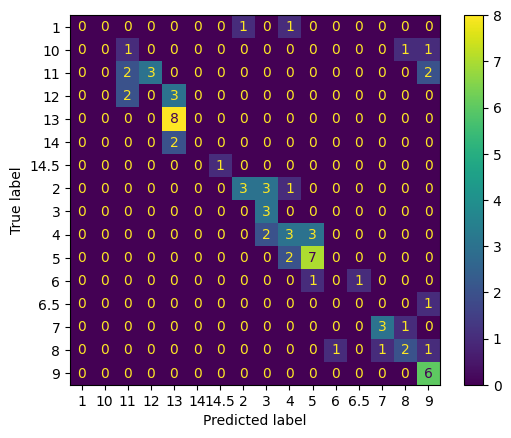

In [46]:
from sklearn.model_selection import cross_val_score

df_fn, df_dims = get_data(fn_path, dims_path)

df = merge_data(df_dims, df_fn)

df = transform_data(df)

outlier_rows = df.loc[df['Speed'].isin(['3.5', '4.5', '5.5'])].index

df.drop(outlier_rows, axis=0, inplace=True)

X = get_features(df, X_cols)

y = get_target(df, y_cols)


X_train, X_test, y_train, y_test = split_data(X, y)

rfc = RandomForestClassifier(
    n_estimators=800,
    max_features=1

)

print(rfc.get_params())

rfc.fit(X_train, np.ravel(y_train))

y_pred = rfc.predict(X_test)

scores = cross_val_score(rfc, X, np.ravel(y), cv=5)
print(scores)

print('Accuracy:', accuracy_score(np.ravel(y_test), y_pred))


#print('R2:', r2_score(y_test, y_pred))
#print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(np.ravel(y_test), np.ravel(y_pred))



<Axes: xlabel='Speed', ylabel='count'>

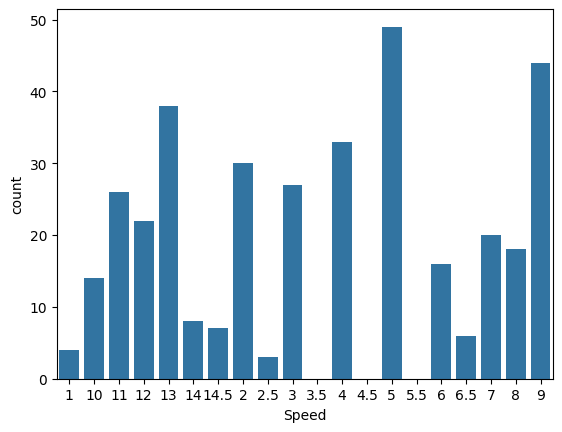

In [47]:
sns.countplot(df, x='Speed')

In [48]:
df.loc[df['Speed'].isin(['3.5', '4.5', '5.5'])].index

Index([], dtype='int64')

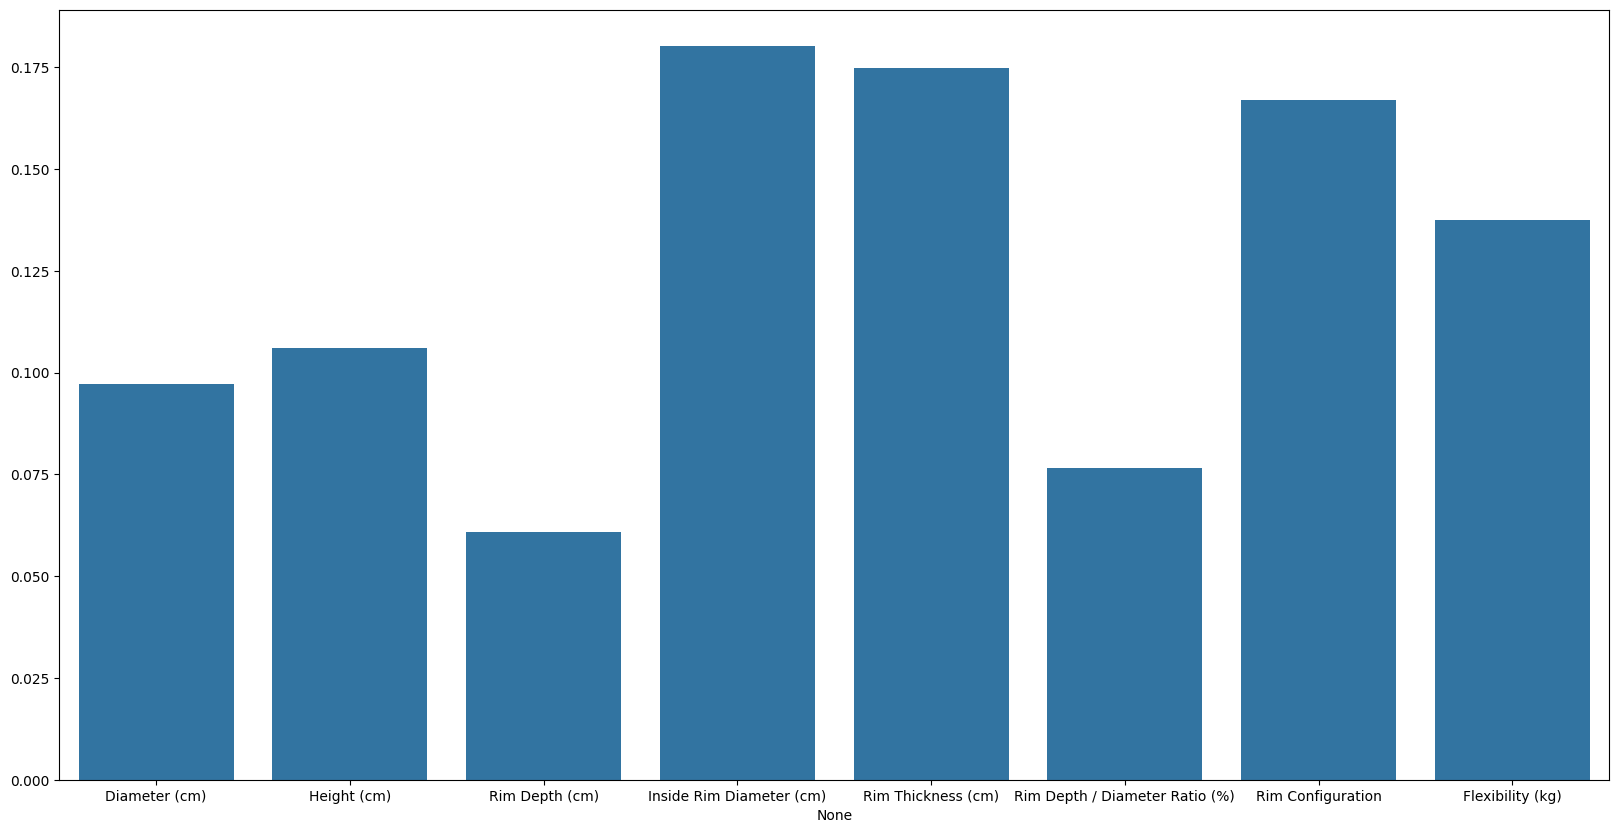

In [49]:
rfc_importances = rfc.feature_importances_

x_axis = X.columns

plt.figure(figsize=(20, 10))

fig = sns.barplot(x=x_axis, y=rfc_importances)



In [30]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

perm_rfc_importances = pd.Series(result.importances_mean, index=X.columns)

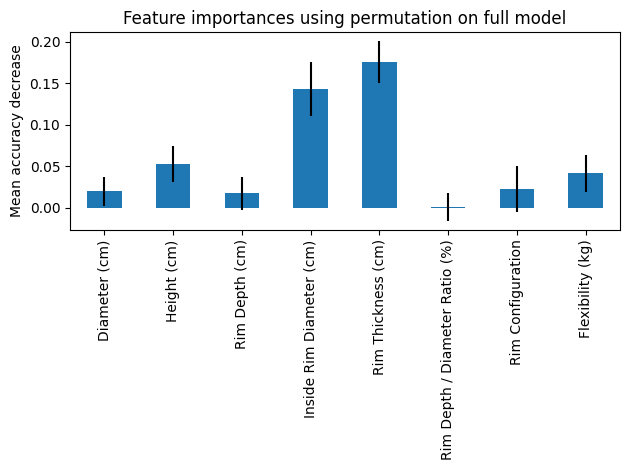

In [31]:
fig, ax = plt.subplots()
perm_rfc_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [28]:
df['Flexibility (kg)'].corr(df['Speed'])

0.48201448781956185